In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [2]:
# Вспомогательная функция для доступа к файлам относительно корня директория с данными.
INPUT_ROOT = "../input/gtsrb-german-traffic-sign"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [3]:
# Загружаем таблицу с данными о данных.
train_info = pd.read_csv(from_input("Train.csv"))
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Посмотрим как выглядят наши данные.
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
# сколько примеров в каждом из классов
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [6]:
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
test_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [8]:
# сколько примеров в каждом из классов
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Показываем изображения в сетке 6х8.
nrows = 8
ncols = 6

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [10]:
def show_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    for i in range(43):
        # subplot индексы начинаются с 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        subdir = os.path.join(from_input('train'), str(i))
        files = os.listdir(subdir)
        img_path = os.path.join(subdir, files[offset % len(files)])
        img = mpimg.imread(img_path)
        #print(img.shape)
        plt.imshow(img)

    plt.show()

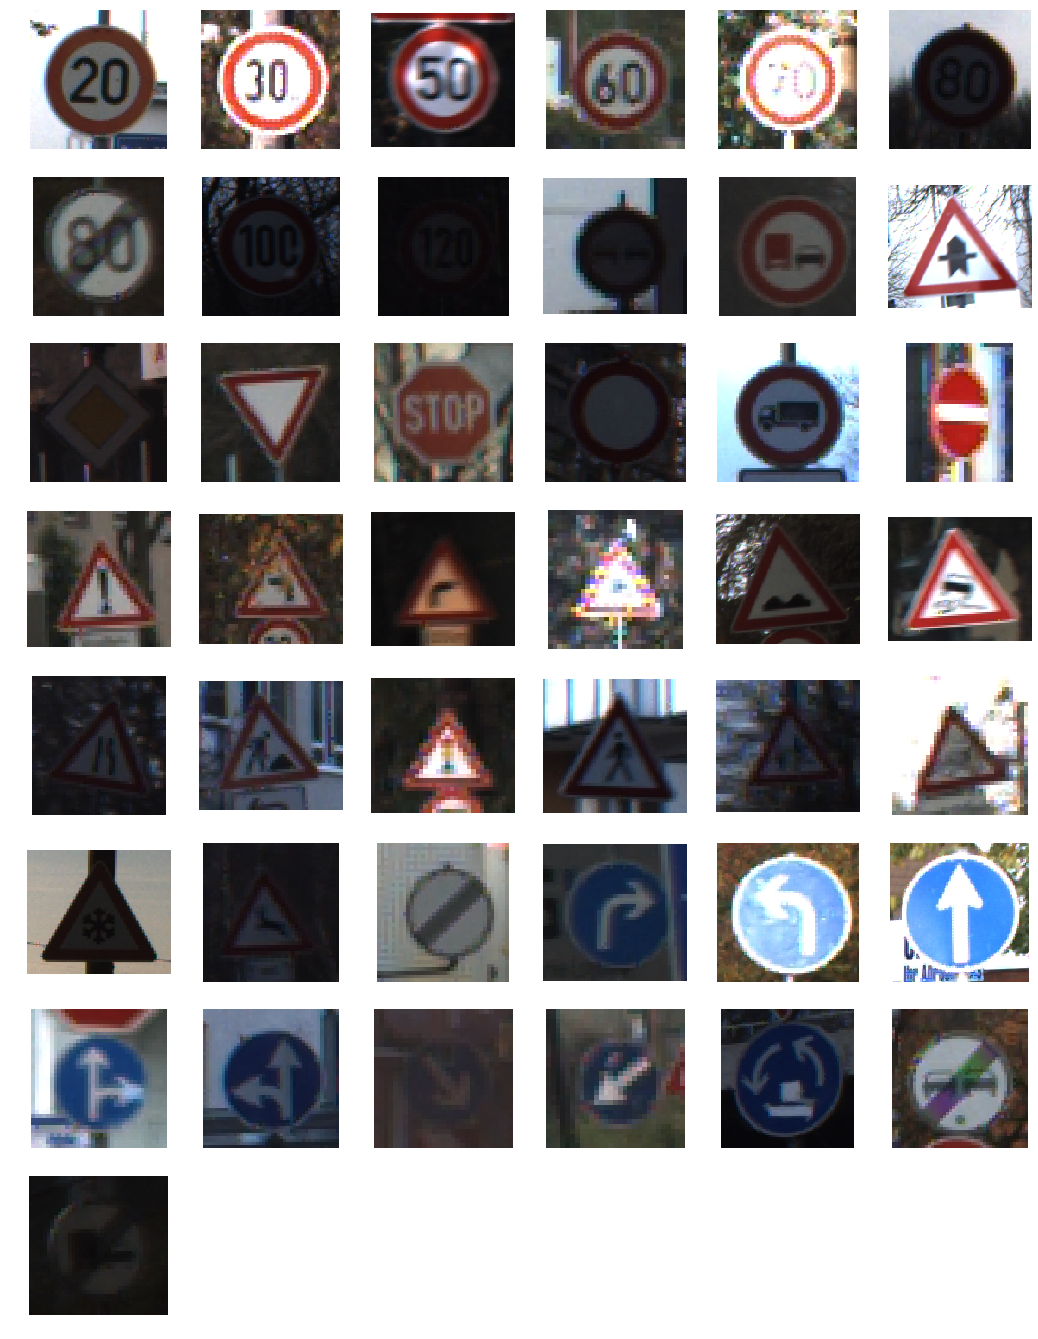

In [11]:
show_images(pic_offset)
pic_offset += 1

Загрузка и подготовка данных:

In [12]:
VALIDATION_RATIO = 0.2 # часть изображений в валидационной выборке
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера

In [13]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]

data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = Image.open(os.path.join(from_input('train'), f.replace('Train/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_train = np.array(data).astype('float32') / 255.0

split_size = 1 - VALIDATION_RATIO
train_size = int(y_train.shape[0] * split_size)

y_train = to_categorical(y_train, 43)
y_val = y_train[train_size:]
y_train = y_train[:train_size]

X_val = X_train[train_size:]
X_train = X_train[:train_size]

print('Data loaded.              ')

Data loaded.              


Некоторые вспомогательные функции:

In [14]:
class StopOnAccReachedCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['acc'] >= 0.999 and logs['val_acc'] >= 0.999:
            self.model.stop_training = True
            print("\nReached accuracy {} at epoch {}, stopping...".format(logs['acc'], epoch))

In [15]:
def plot(history):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))

    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.figure()

    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.xlabel('Epoch')
    plt.title('Training and validation loss')

In [16]:
def show_layers(model):
    print('Name\t\t\tOutput shape\t\t\tActivation\t\t\tInitializer')
    for l in model.layers:
        print('{0}({1})\t\t{2}\t\t\t{3}\t\t\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [17]:
VERBOSE=0

In [18]:
def train_model(model, kernel_initializer, optimizer, epochs):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    BATCH_SIZE = 300
    start_time = timer()
    history = model.fit(X_train,
                        y_train,
                        batch_size = BATCH_SIZE,
                        epochs=epochs,
                        shuffle=False,
                        verbose=VERBOSE,
                        callbacks=[
                          tf.keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=2),
                          StopOnAccReachedCallback()
                        ],
                        steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE),
                        validation_data = (X_val, y_val))
    end_time = timer()
    
    custom_summary(model)
    print('==============================')
    print('Initializer: ', kernel_initializer)
    print('Optimizer: ', optimizer.__class__.__name__)
    print('Learning rate: ', optimizer.get_config()['learning_rate'])
    print('Epochs: ', epochs)
    print('==============================')
    print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
    acc=history.history['acc'][-1]
    val_acc=history.history['val_acc'][-1]
    print('Results at the end of training: acc={1:.02f}%, val_acc={2:.02f}%'
          .format(i, acc*100, val_acc*100))
    plot(history)

Тренируем сети:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               614528    
_________________________________________________________________
dense_1 (Dense)              (None, 43)                5547      
Total params: 620,075
Trainable params: 620,075
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten(Flatten)		(None, 4800)			<none>			<none>
dense(Dense)		(None, 128)			relu			GlorotUniform
dense_1(Dense)		(None, 43)			softmax			GlorotUniform
Initializer:  glorot_uniform
Optimizer:  RMSprop
Learning rate:  0.001
Epochs:  20
Trained in 4.83 minutes
Results at the end of training: acc=90.31%, val_acc=89.15%


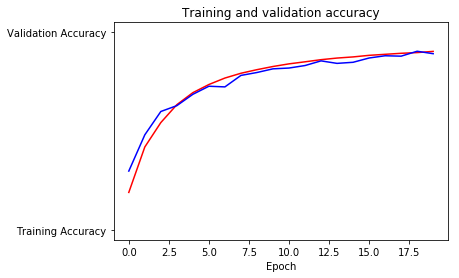

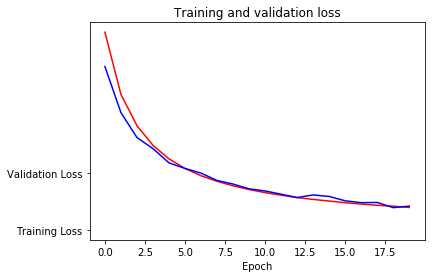

In [19]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.001)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Попробуем добавлять слои:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               614528    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 43)                5547      
Total params: 636,587
Trainable params: 636,587
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_1(Flatten)		(None, 4800)			<none>			<none>
dense_2(Dense)		(None, 128)			relu			GlorotUniform
dense_3(Dense)		(None, 128)			relu			GlorotUniform
dense_4(Dense)		(None, 43)			softmax			GlorotU

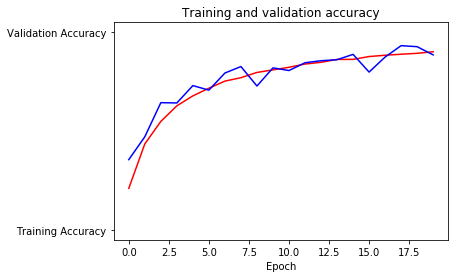

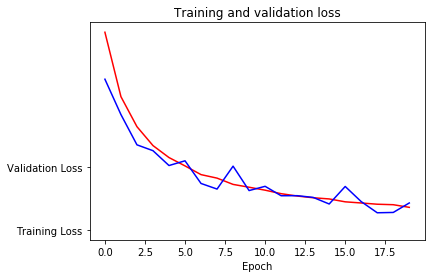

In [20]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Результат не улучшился. Но ошибка на валидационной выборке стал нестабильным. Попробуем уменьшить параметр обучения.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               614528    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 43)                5547      
Total params: 636,587
Trainable params: 636,587
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_2(Flatten)		(None, 4800)			<none>			<none>
dense_5(Dense)		(None, 128)			relu			GlorotUniform
dense_6(Dense)		(None, 128)			relu			GlorotUniform
dense_7(Dense)		(None, 43)			softmax			GlorotU

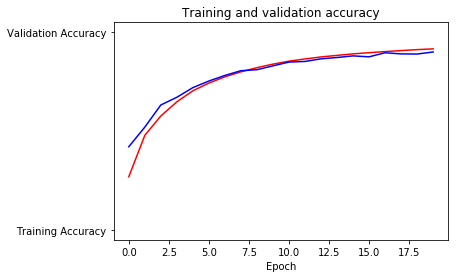

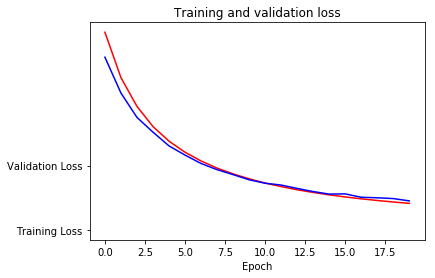

In [21]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Всё стало лучше. Попробуем добавить ещё один слой.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               614528    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 43)                5547      
Total params: 653,099
Trainable params: 653,099
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_3(Flatten)		(None, 4800)			<none>			<none>
dense_8(Dense)		

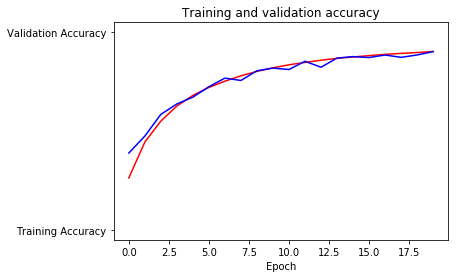

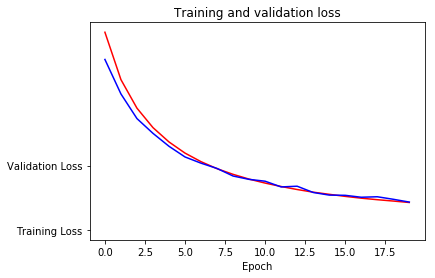

In [22]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Стало хуже. На всякий случай добавим ещё один слой.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               614528    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 43)                5547      
Total params: 669,611
Trainable params: 669,611
Non-trainable params: 0
________________________________________________

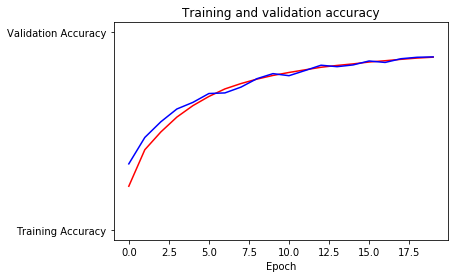

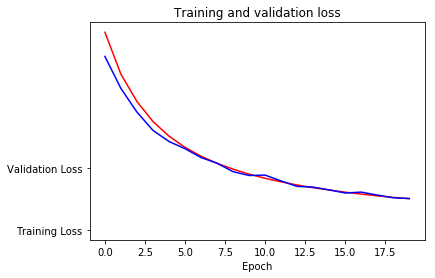

In [23]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Тренд остался, добавление слоёв не помогает. Также не повышает время тренировки значительно. Попробуем изменить количество нейронов в сети с двумя и тремя слоями.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_5(Flatten)		(None, 4800)			<none>			<none>
dense_17(Dense)		(None, 256)			relu			GlorotUniform
dense_18(Dense)		(None, 128)			relu			GlorotUniform
dense_19(Dense)		(None, 43)			softmax			

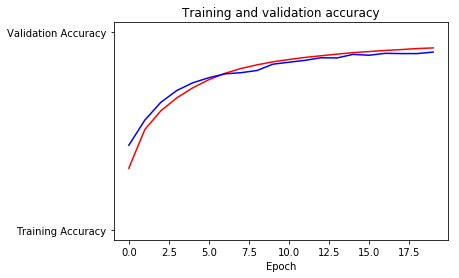

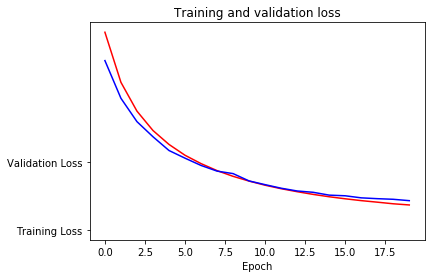

In [24]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 43)                2795      
Total params: 1,273,003
Trainable params: 1,273,003
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_6(Flatten)		(None, 4800)			<none>			<none>
dense_20(Den

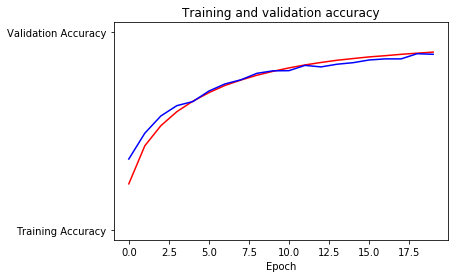

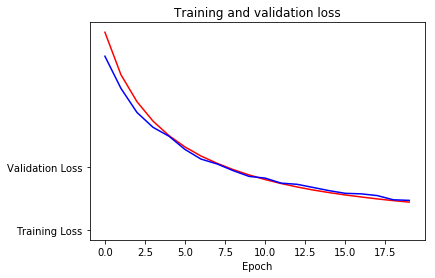

In [25]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(64, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Время тренировки увеличивается, но и точность. Два слоя лучше трёх. На такой сетке попробуем исследовать влияние алгоритма оптимизации. Для Адама понизим ещё параметр обучения, так как он обычно быстро сходится, а для SGD наоборот.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_7(Flatten)		(None, 4800)			<none>			<none>
dense_24(Dense)		(None, 256)			relu			GlorotUniform
dense_25(Dense)		(None, 128)			relu			GlorotUniform
dense_26(Dense)		(None, 43)			softmax			

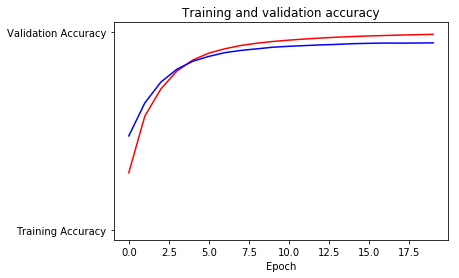

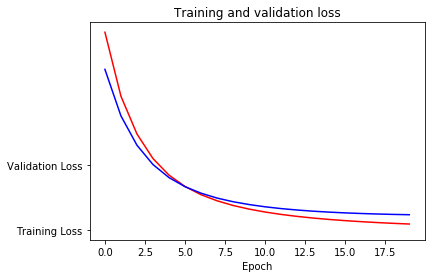

In [26]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.00005)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_8(Flatten)		(None, 4800)			<none>			<none>
dense_27(Dense)		(None, 256)			relu			GlorotUniform
dense_28(Dense)		(None, 128)			relu			GlorotUniform
dense_29(Dense)		(None, 43)			softmax			

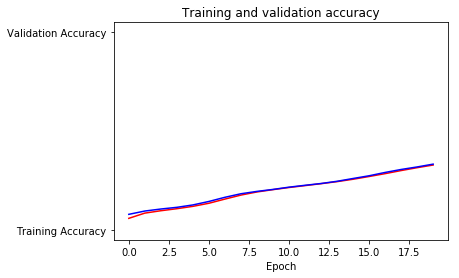

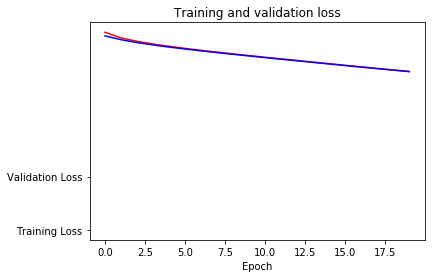

In [27]:
kernel_initializer='glorot_uniform'
optimizer=SGD(learning_rate=0.001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

In [28]:
Адам даёт лучший результат. Продолжим его использовать. Теперь исследуем влияние функции активации.

SyntaxError: invalid syntax (<ipython-input-28-415070530a14>, line 1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_9(Flatten)		(None, 4800)			<none>			<none>
dense_30(Dense)		(None, 256)			sigmoid			GlorotUniform
dense_31(Dense)		(None, 128)			sigmoid			GlorotUniform
dense_32(Dense)		(None, 43)			soft

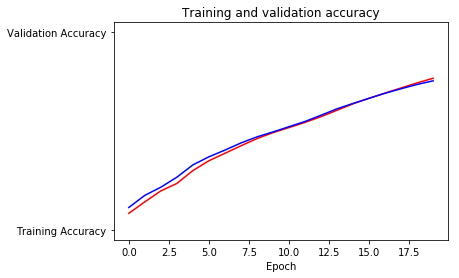

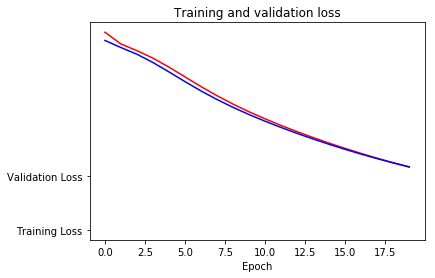

In [29]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.00005)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='sigmoid', kernel_initializer=kernel_initializer),
    Dense(128, activation='sigmoid', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_10(Flatten)		(None, 4800)			<none>			<none>
dense_33(Dense)		(None, 256)			tanh			GlorotUniform
dense_34(Dense)		(None, 128)			tanh			GlorotUniform
dense_35(Dense)		(None, 43)			softmax	

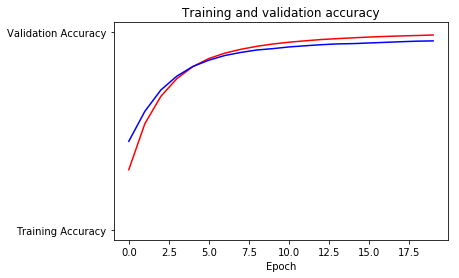

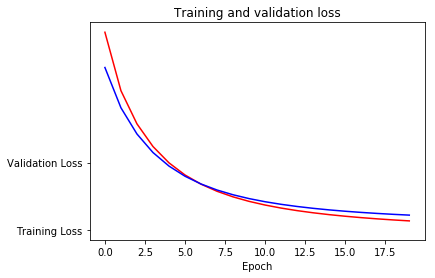

In [30]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.00005)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Гиперболический тангенс даёт лучшие результаты. Продолжим его использовать и попробуем другие методы инициализации весов.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_38 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_11(Flatten)		(None, 4800)			<none>			<none>
dense_36(Dense)		(None, 256)			tanh			GlorotNormal
dense_37(Dense)		(None, 128)			tanh			GlorotNormal
dense_38(Dense)		(None, 43)			softmax			

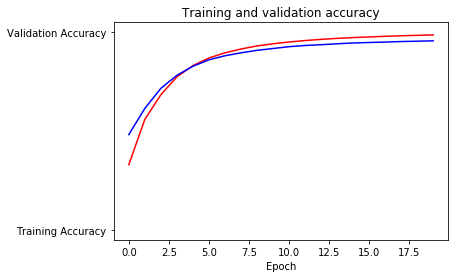

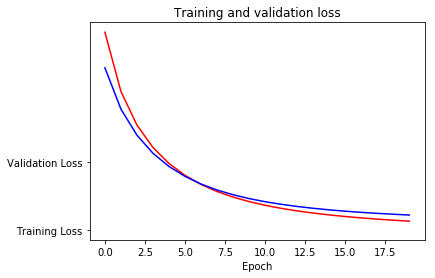

In [31]:
kernel_initializer='glorot_normal'
optimizer=Adam(learning_rate=0.00005)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_41 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_12(Flatten)		(None, 4800)			<none>			<none>
dense_39(Dense)		(None, 256)			tanh			VarianceScaling
dense_40(Dense)		(None, 128)			tanh			VarianceScaling
dense_41(Dense)		(None, 43)			soft

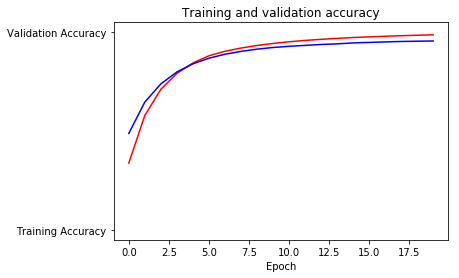

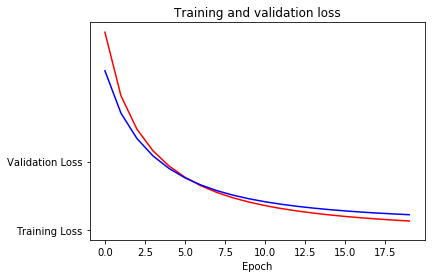

In [32]:
kernel_initializer='he_normal'
optimizer=Adam(learning_rate=0.00005)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_44 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_13(Flatten)		(None, 4800)			<none>			<none>
dense_42(Dense)		(None, 256)			tanh			VarianceScaling
dense_43(Dense)		(None, 128)			tanh			VarianceScaling
dense_44(Dense)		(None, 43)			soft

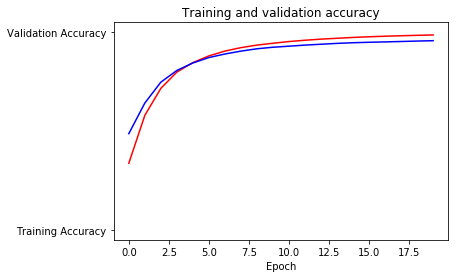

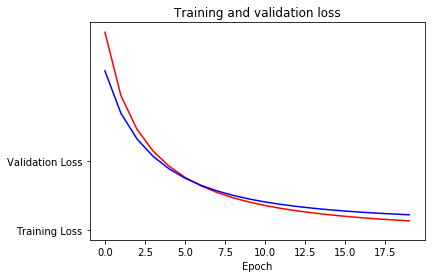

In [33]:
kernel_initializer='he_uniform'
optimizer=Adam(learning_rate=0.00005)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Нет особой разницы. Ещё попробуем тренировать больше эпох.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               1229056   
_________________________________________________________________
dense_46 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_47 (Dense)             (None, 43)                5547      
Total params: 1,267,499
Trainable params: 1,267,499
Non-trainable params: 0
_________________________________________________________________
Name			Output shape			Activation			Initializer
flatten_14(Flatten)		(None, 4800)			<none>			<none>
dense_45(Dense)		(None, 256)			tanh			VarianceScaling
dense_46(Dense)		(None, 128)			tanh			VarianceScaling
dense_47(Dense)		(None, 43)			soft

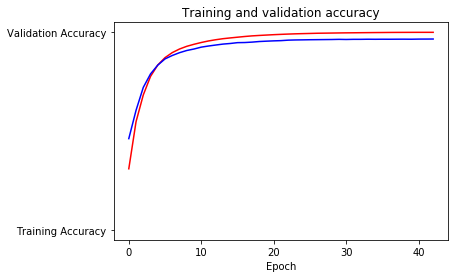

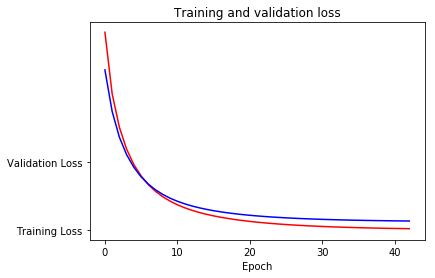

In [34]:
kernel_initializer='he_uniform'
optimizer=Adam(learning_rate=0.00005)
epochs=50

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Посмотрим тестовую выборку.

In [35]:
# Показываем изображения в сетке 3x5
nrows = 3
ncols = 5

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [36]:
def show_test_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)
    paths = test_info['Path'].values
    offset = offset * ncols * nrows

    for i in range(ncols * nrows):
        f = paths[(offset + i) % len(paths)]
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img_path = os.path.join(from_input('test'), f.replace('Test/', ''))
        img = mpimg.imread(img_path)
        plt.imshow(img) 

    plt.show()

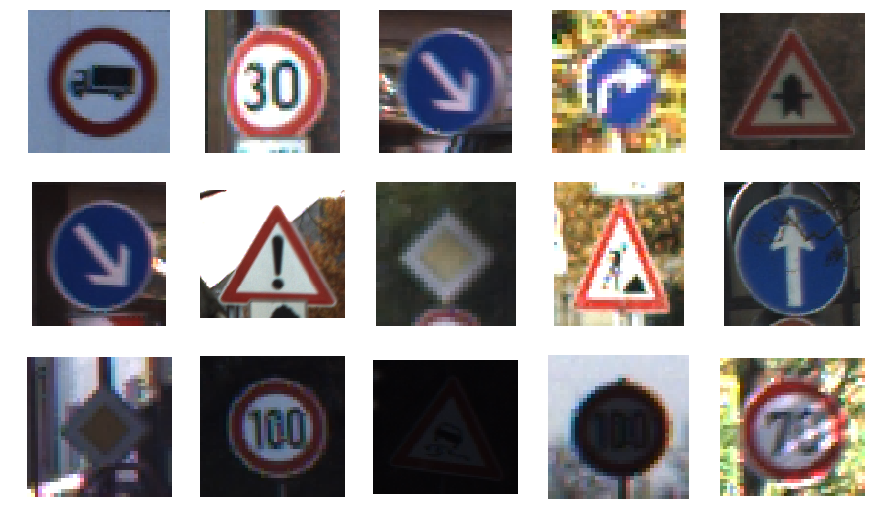

In [37]:
show_test_images(pic_offset)
pic_offset += 1

In [38]:
# Тестируем
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

data=[]

for f in paths:
    image = Image.open(os.path.join(from_input('test'), f.replace('Test/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_test = np.array(data).astype('float32') / 255.0 

In [39]:
result = model.evaluate(X_test, y_test)
print(model.metrics_names)
print(result)

12630/12630 [==============================] - 1s 66us/sample - loss: 0.5062 - acc: 0.8684
['loss', 'acc']
[0.506206078894631, 0.86840856]


Сеть не обобщается хорошо на тестовую выборку. Методы регуляризации могут помочь, но снача надо попробовать свёрточные сети.